In [2]:
#Some initial declarations and imports
from ema_workbench import (
    Model,
    CategoricalParameter,
    ScalarOutcome,
    IntegerParameter,
    RealParameter,
    MultiprocessingEvaluator,
    Constraint,
    ema_logging
)

from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.optimization import (EpsilonProgress,
                                                     ArchiveLogger)
import pandas as pd
import pickle
import os


from vis import make_scenario, calc_all_outcomes, visualize_epsilon_progress

from model.dike_model_function import DikeNetwork, sum_over
#Instantiate model with one time step
dike_model = Model("dikesnet", function=DikeNetwork(1))

#Defined reference scenarios discovered in scenario discovery as specified in the report
scenario_specs = [{'name': 'Worst case 1a, Dike 1 strong', 'Bmax': 175, 'Brate': 1.5,
                       'pfails': [1, 0.5, 0.5, 0.5, 0.5],
                  'discount_rate': 3.5, 'ID_flood_wave_shape': 4},
                      {'name': 'Worst case 1b, Dike 3 fails', 'Bmax': 175, 'Brate': 1.5,
                       'pfails': [0, 0.5, 0, 0.5, 0.5],
                  'discount_rate': 3.5, 'ID_flood_wave_shape': 4},
                      {'name': 'Worst case 1c, from scenario discovery', 'Bmax': 175, 'Brate': 1.5,
                       'pfails': [1, 0.5, 0, 0.5, 0.5],
                  'discount_rate': 3.5, 'ID_flood_wave_shape': 4},
                      {'name': 'worst case 2, expensive', 'Bmax': 175, 'Brate': 1.5,
                       'pfails': [0.5, 0.5, 0.5, 0.5, 0.5],
                  'discount_rate': 1.5, 'ID_flood_wave_shape': 4},
                      {'name': 'Worst worst case', 'Bmax': 175, 'Brate': 1.5,
                       'pfails': [1, 0.5, 0, 0.5, 0.5],
                  'discount_rate': 1.5, 'ID_flood_wave_shape': 4}, ]
#Instantiate refference scenarios
ref_scenarios = []
for spec in scenario_specs:
    ref_scenarios.append(make_scenario(**spec))

#Outcomes that are constrained
constraint_names =  ['A.1_Expected Number of Deaths',
                            'A.2_Expected Number of Deaths',
                            'A.3_Expected Number of Deaths',
                            'A.4_Expected Number of Deaths',
                            'A.5_Expected Number of Deaths']

pickle_files_folder_path = 'archives/pickle_files/'

C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\ema_workbench\em_framework\evaluators.py:58: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")
C:\Drive sync\study\Y3\Q4\epa1361_open\venv\Lib\site-packages\ema_workbench\analysis\prim.py:30: ImportWarning: altair based interactive inspection not available
  warnings.warn(("altair based interactive " "inspection not available"), ImportWarning)


# Problem formulation

A problem formulation consists of three things. Uncertainties and levers / policies and outcomes. Our problem formulation uses the configuration of standard formulation 3. We will however disregard the evacuation cost and total cost for RFR. We do this because our dikes do not care about this. Additionally, we will also handle the ammount of expected deaths as a constraing to be kept under 0,1 in total and thus under 0,02 per dike.
### Uncertainties

In [3]:
# Uncertainties and Levers:
# Specify uncertainties range:
Real_uncert = {"Bmax": [30, 350], "pfail": [0, 1]}  # m and [.]
# breach growth rate [m/day]
cat_uncert_loc = {"Brate": (1.0, 1.5, 10)}

cat_uncert = {
    f"discount rate {n}": (1.5, 2.5, 3.5, 4.5) for n in dike_model.function.planning_steps
}

Int_uncert = {"A.0_ID flood wave shape": [0, 132]}

uncertainties = []
levers = []

for uncert_name in cat_uncert.keys():
    categories = cat_uncert[uncert_name]
    uncertainties.append(CategoricalParameter(uncert_name, categories))

for uncert_name in Int_uncert.keys():
    uncertainties.append(
        IntegerParameter(
            uncert_name, Int_uncert[uncert_name][0], Int_uncert[uncert_name][1]
        )
    )

for dike in dike_model.function.dikelist:
    # uncertainties in the form: locationName_uncertaintyName
    for uncert_name in Real_uncert.keys():
        name = f"{dike}_{uncert_name}"
        lower, upper = Real_uncert[uncert_name]
        uncertainties.append(RealParameter(name, lower, upper))

    for uncert_name in cat_uncert_loc.keys():
        name = f"{dike}_{uncert_name}"
        categories = cat_uncert_loc[uncert_name]
        uncertainties.append(CategoricalParameter(name, categories))

problem = get_SALib_problem(uncertainties)
dike_model.uncertainties = uncertainties
uncertainties

[CategoricalParameter('discount rate 0', [0, 1, 2, 3]),
 IntegerParameter('A.0_ID flood wave shape', 0, 132, resolution=None, default=None, variable_name=['A.0_ID flood wave shape'], pff=False),
 RealParameter('A.1_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.1_Bmax'], pff=False),
 RealParameter('A.1_pfail', 0, 1, resolution=None, default=None, variable_name=['A.1_pfail'], pff=False),
 CategoricalParameter('A.1_Brate', [0, 1, 2]),
 RealParameter('A.2_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.2_Bmax'], pff=False),
 RealParameter('A.2_pfail', 0, 1, resolution=None, default=None, variable_name=['A.2_pfail'], pff=False),
 CategoricalParameter('A.2_Brate', [0, 1, 2]),
 RealParameter('A.3_Bmax', 30, 350, resolution=None, default=None, variable_name=['A.3_Bmax'], pff=False),
 RealParameter('A.3_pfail', 0, 1, resolution=None, default=None, variable_name=['A.3_pfail'], pff=False),
 CategoricalParameter('A.3_Brate', [0, 1, 2]),
 RealParameter('A.4_Bmax'

### levers

In [4]:
# Range of dike heightening:
dike_lev = {"DikeIncrease": [0, 10]}  # dm

# Series of five Room for the River projects:
rfr_lev = [f"{project_id}_RfR" for project_id in range(0, 5)]

# Time of warning: 0, 1, 2, 3, 4 days ahead from the flood
EWS_lev = {"EWS_DaysToThreat": [0, 4]}  # days

# RfR levers can be either 0 (not implemented) or 1 (implemented)
for lev_name in rfr_lev:
    for n in dike_model.function.planning_steps:
        lev_name_ = f"{lev_name} {n}"
        levers.append(IntegerParameter(lev_name_, 0, 1))

# Early Warning System lever
for lev_name in EWS_lev.keys():
    levers.append(
        IntegerParameter(lev_name, EWS_lev[lev_name][0], EWS_lev[lev_name][1])
    )

for dike in dike_model.function.dikelist:
    # location-related levers in the form: locationName_leversName
    for lev_name in dike_lev.keys():
        for n in dike_model.function.planning_steps:
            name = f"{dike}_{lev_name} {n}"
            levers.append(
                IntegerParameter(name, dike_lev[lev_name][0], dike_lev[lev_name][1])
            )

# load uncertainties and levers in dike_model:
dike_model.levers = levers
levers

[IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False),
 IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False),
 IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False),
 IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False),
 IntegerParameter('4_RfR 0', 0, 1, resolution=None, default=None, variable_name=['4_RfR 0'], pff=False),
 IntegerParameter('EWS_DaysToThreat', 0, 4, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False),
 IntegerParameter('A.1_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.1_DikeIncrease 0'], pff=False),
 IntegerParameter('A.2_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.2_DikeIncrease 0'], pff=False),
 IntegerParameter('A.3_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.

### Outcomes

In [5]:
outcomes = []

for dike in dike_model.function.dikelist:
    cost_variables = []
    for e in ["Expected Annual Damage", "Dike Investment Costs"]:
        cost_variables.append(f"{dike}_{e}")

    outcomes.append(
        ScalarOutcome(
            f"{dike} Total Costs",
            variable_name=[var for var in cost_variables],
            function=sum_over,
            kind=ScalarOutcome.MINIMIZE,
        )
    )

    outcomes.append(
        ScalarOutcome(
            f"{dike}_Expected Number of Deaths",
            variable_name=f"{dike}_Expected Number of Deaths",
            function=sum_over,
            kind=ScalarOutcome.MINIMIZE,
        )
    )

outcomes.append(
    ScalarOutcome(
        "RfR Total Costs",
        variable_name="RfR Total Costs",
        function=sum_over,
    )
)
outcomes.append(
    ScalarOutcome(
        "Expected Evacuation Costs",
        variable_name="Expected Evacuation Costs",
        function=sum_over,
    )
)
dike_model.outcomes = outcomes
outcomes

[ScalarOutcome('A.1 Total Costs', variable_name=('A.1_Expected Annual Damage', 'A.1_Dike Investment Costs'), function=<function sum_over at 0x000001D979404C20>),
 ScalarOutcome('A.1_Expected Number of Deaths', variable_name=('A.1_Expected Number of Deaths',), function=<function sum_over at 0x000001D979404C20>),
 ScalarOutcome('A.2 Total Costs', variable_name=('A.2_Expected Annual Damage', 'A.2_Dike Investment Costs'), function=<function sum_over at 0x000001D979404C20>),
 ScalarOutcome('A.2_Expected Number of Deaths', variable_name=('A.2_Expected Number of Deaths',), function=<function sum_over at 0x000001D979404C20>),
 ScalarOutcome('A.3 Total Costs', variable_name=('A.3_Expected Annual Damage', 'A.3_Dike Investment Costs'), function=<function sum_over at 0x000001D979404C20>),
 ScalarOutcome('A.3_Expected Number of Deaths', variable_name=('A.3_Expected Number of Deaths',), function=<function sum_over at 0x000001D979404C20>),
 ScalarOutcome('A.4 Total Costs', variable_name=('A.4_Expecte

# MOEA's
Now we will use the platypus opt implementation of EpsNSGAII. This algorithm uses epsilon values to construct a grid of 1/epsilon value squares per outcome. The epsilon values define the granularity of the search. We use epsilon values of 0.2 making for five squares per outcome as this is enough for our purposes as the constraints are most important. Additionally, this algorithm allows for constraints. We will define individual expected deaths to be at most 0.02 per dike to a total maximum of 0.1. We do this because our dikes are death averse. We choose not to take into account the total cost for RFR or the cost of evacuation as these are not important to our dike rings. Just deaths and cost to them are important. We have constructed five reference scenarios based on scenario exploration in the other notebook, and we will look for an optimal policy for each of these reference scenarios. To be able to know the quality of resulting policies of the generational EpsNSGAII algorithm we will look at the epsilon progress the algorithm makes. This way we know if it has sufficiently converged toward a policy that can only improve marginally.

In [7]:
#There are five files associated with this experiment so, please manually choose to re-run the experiment
re_do_MOAE = False
if re_do_MOAE:
    #Set epsilons for each outcome
    epsilons = [0.2,]*10
    #Set convergence metric
    convergence_metrics = [EpsilonProgress()]

    #Construct constraints for expected deaths as discussed in the report
    constraints = []
    for constraint_name in constraint_names:
        constraints.append(Constraint(constraint_name, outcome_names=constraint_name,
                          function=lambda x: max(0, x - 0.02)))

    #Run an MOAE per refference scenario and save the results
    for scenario in ref_scenarios:
        with MultiprocessingEvaluator(dike_model) as evaluator:
            experiment, convergence = evaluator.optimize(nfe=5e3,
                                        searchover='levers',
                                        epsilons=epsilons,
                                        reference=scenario,
                                        convergence=convergence_metrics,
                                        constraints=constraints)
        with open(pickle_files_folder_path + 'Scenario ' + scenario.name + '.pickle', 'wb') as file:
            pickle.dump((scenario, experiment, convergence), file)

5070it [02:47, 30.32it/s]                                                      
5055it [03:04, 27.33it/s]                                                      
5078it [03:04, 27.48it/s]                                                      
5080it [02:43, 31.12it/s]                                                      
5043it [02:52, 29.29it/s]                                                      


Number of found policies for scenario  Worst case 1a, Dike 1 strong :  15


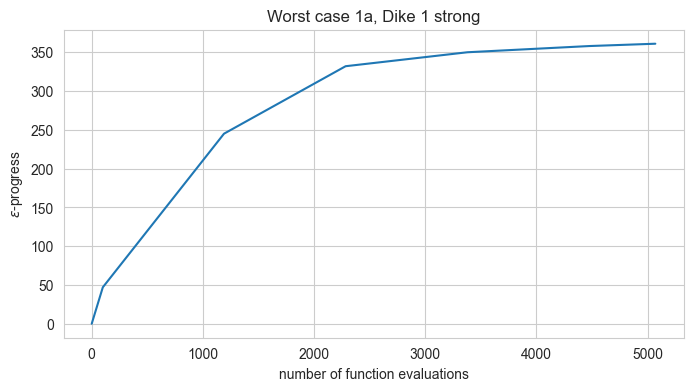

Number of found policies for scenario  Worst case 1b, Dike 3 fails :  1


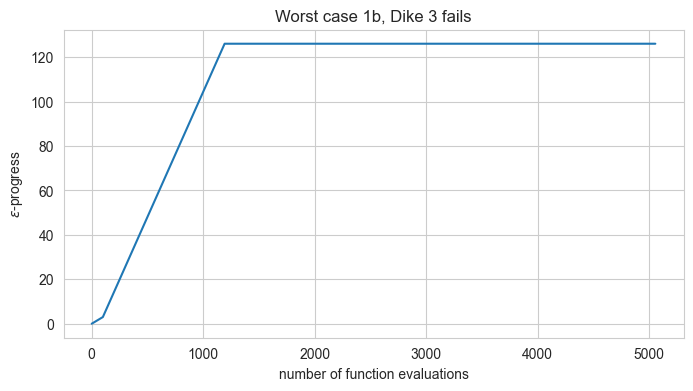

Number of found policies for scenario  Worst case 1c, from scenario discovery :  1


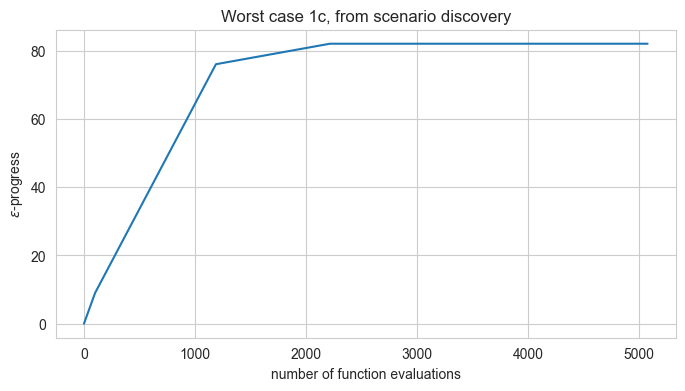

Number of found policies for scenario  worst case 2, expensive :  30


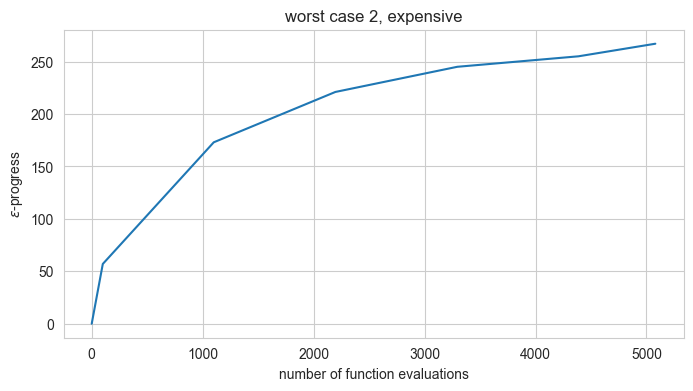

Number of found policies for scenario  Worst worst case :  1


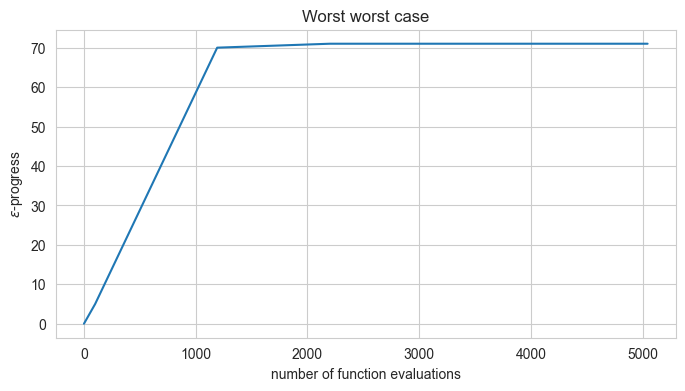

In [9]:
#Plot the convergence metric: epsilon progress and write the found policies into an Excel file
once = False
idx = 0
rows = []
for scenario in ref_scenarios:
    with open(pickle_files_folder_path + 'Scenario ' + scenario.name + '.pickle', 'rb') as file:
        scenario, results, convergence = pickle.load(file)
        print('Number of found policies for scenario ', scenario.name, ': ', len(results))
        results = calc_all_outcomes(results)
        #Set columns once
        if not once:
            row = ['Scenario_name']
            row.extend(results.columns)
            cols = row
            once = True
        #Add data to rows list
        for row in results.itertuples():
            row_dict = {}
            row = row[1:]
            written_row = [scenario.name]
            written_row.extend(row)
            for key, value in zip(cols, written_row):
                row_dict[key] = value
            row_dict['index'] = idx
            idx += 1
            rows.append(row_dict)
        #plot the epsilon progress
        plt = visualize_epsilon_progress(convergence, scenario.name)
#use pandas to write a tidy excel file into results folder in archives
df = pd.DataFrame(data=rows, columns=cols)
df.to_excel('archives/results/policy_discovery_results.xlsx')

We can observe that in the first scenario there are fifteen possible policies to use. But this is no problem to us as it seems that the algorithem has converged. In the fourth scenario however, the algorithm was still making epsilon progress. That is why we will perform a re-run with more generations for the algorithm to converge toward a policy.

In [10]:
# The fourth scenario needs more iterations to converge
scenario = ref_scenarios[3]
#If not done before do the experiment
experiment_name = 'Second_MOAE_Scenario ' + scenario.name
results_folder_path = 'archives/results/'
path = results_folder_path + experiment_name + '.xlsx'
done_before = os.path.exists(path)

if not done_before:
    #Set epsilons for each outcome
    epsilons = [0.2,]*10
    #Set convergence metric
    convergence_metrics = [EpsilonProgress()]

    #Construct constraints for expected deaths as discussed in the report
    constraints = []
    for constraint_name in constraint_names:
        constraints.append(Constraint(constraint_name, outcome_names=constraint_name,
                          function=lambda x: max(0, x - 0.02)))

    #Run annother MOAE with 9000 nfe nstead of 5000
    with MultiprocessingEvaluator(dike_model) as evaluator:
        experiment, convergence = evaluator.optimize(nfe=9e3,
                                    searchover='levers',
                                    epsilons=epsilons,
                                    reference=scenario,
                                    convergence=convergence_metrics,
                                    constraints=constraints)
    with open(path, 'wb') as f:
        pickle.dump((scenario, experiment, convergence), f)

9054it [04:50, 31.15it/s]                                                      


Number of found policies for scenario  worst case 2, expensive :  15


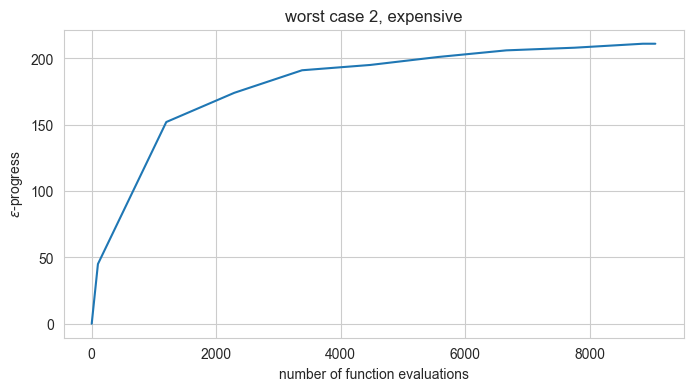

In [14]:
#Visualize results of the second run
once = False
idx = 0
rows = []
scenario = ref_scenarios[3]
with open(path, 'rb') as file:
    scenario, results, convergence = pickle.load(file)
    print('Number of found policies for scenario ', scenario.name, ': ', len(results))
    results = calc_all_outcomes(results)
    if not once:
        row = ['Scenario_name']
        row.extend(results.columns)
        cols = row
        once = True
    for row in results.itertuples():
        row_dict = {}
        row = row[1:]
        written_row = [scenario.name]
        written_row.extend(row)
        for key, value in zip(cols, written_row):
            row_dict[key] = value
        row_dict['index'] = idx
        idx += 1
        rows.append(row_dict)
    plt = visualize_epsilon_progress(convergence, scenario.name)
df = pd.DataFrame(data=rows, columns=cols)
df.to_excel('archives/results/second_policy_discovery_results.xlsx')

# The policy advice
The policy advice is constructed in the report using the results generated and saved in the archives/results folder as excel files.

In [15]:
# to share the dependencies
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
